In [2]:
import skrf as rf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

# Last inn S11-data
filnavn = "Måling/RadiokomAntenne.s1p"
antenne = rf.Network(filnavn)

# Frekvens i Hz og S11 i dB
freq = antenne.f / 1e9
s11_db = antenne.s11.s_db.flatten()
df=pd.DataFrame({'Frequency [GHz]': freq, 'S11 [dB]': s11_db})
df['S11 [dB]'] = df['S11 [dB]'].rolling(window=20, center=True).mean() # Glatting av S11-data

# find S11 at a certain frequency
LO_freq = 2.425 # Target frequency in Hz
freq_target_index = np.argmin(np.abs(df['Frequency [GHz]'] - LO_freq))
LO_s11 = df['S11 [dB]'].iloc[freq_target_index]
print(f"S11 at {LO_freq:.3f} GHz: {LO_s11:.1f} dB")

# find all local minima in S11 & under -5 dB

s11_minima = df.iloc[argrelextrema(df['S11 [dB]'].values, np.less_equal, order=20)[0]]
s11_minima = s11_minima[s11_minima['S11 [dB]'] < -5] 

minima_str = "Lokale Minima:"
for index, row in s11_minima.iterrows():
    minima_str += f"\n({row['Frequency [GHz]']:.3f} GHz, {row['S11 [dB]']:.1f} dB)"
print(minima_str)

S11 at 2.425 GHz: -2.8 dB
Lokale Minima:
(0.930 GHz, -13.3 dB)
(1.992 GHz, -26.7 dB)
(2.728 GHz, -9.8 dB)
(4.196 GHz, -7.6 dB)
(5.889 GHz, -12.5 dB)


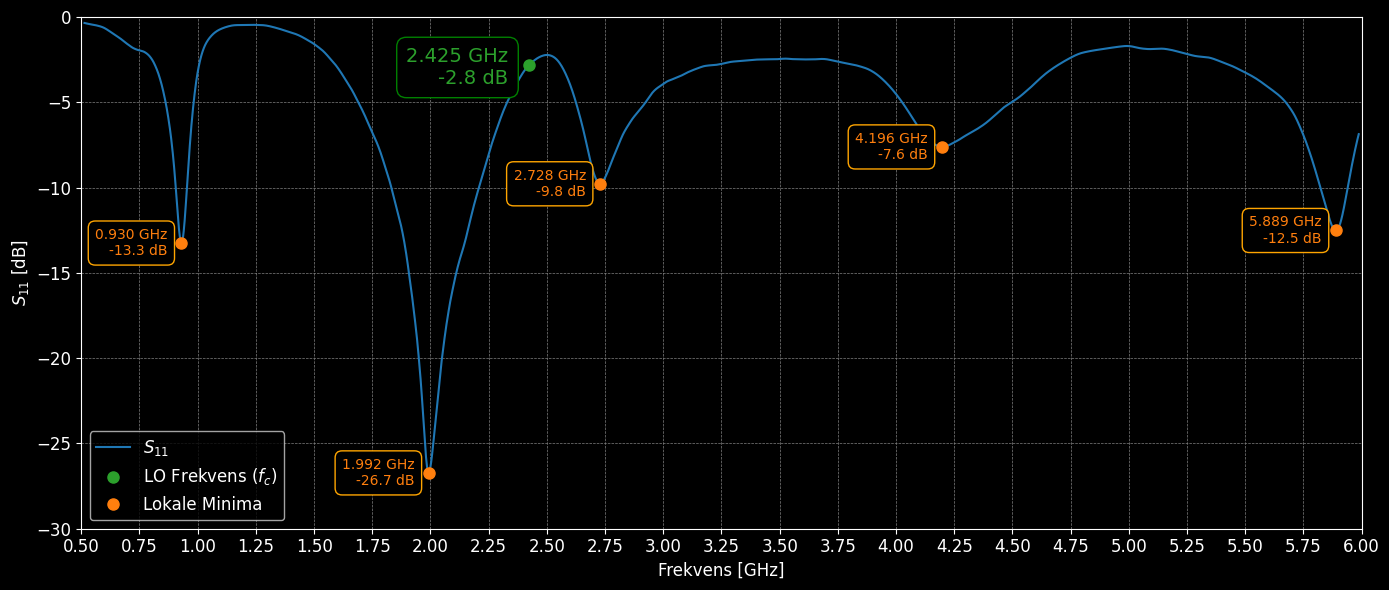

In [3]:
# Plot hele 
plt.style.use('dark_background')
plt.figure(figsize=(14, 6))

# Plotting S11 data
plt.plot(df['Frequency [GHz]'], df['S11 [dB]'], label=r"$S_{11}$", color='tab:blue')

# LO frekvens
plt.plot(LO_freq, LO_s11, 'o', label=r"LO Frekvens ($f_c$)", color='tab:green', markersize=8)
plt.annotate(f"{LO_freq:.3f} GHz\n{LO_s11:.1f} dB", xy=(LO_freq, LO_s11), xytext=(-15, -2), textcoords='offset points', fontsize=14, color='tab:green', ha='right', va='center', bbox=dict(boxstyle="round,pad=0.5", edgecolor='green', facecolor='black', alpha=1))

# Loakle Minimum
plt.plot(s11_minima['Frequency [GHz]'], s11_minima['S11 [dB]'], 'o', label="Lokale Minima", color='tab:orange', markersize=8)
for index, row in s11_minima.iterrows():
    plt.annotate(f"{row['Frequency [GHz]']:.3f} GHz\n{row['S11 [dB]']:.1f} dB", xy=(row['Frequency [GHz]'], row['S11 [dB]']), xytext=(-10, 0), textcoords='offset points', fontsize=10, color='tab:orange',ha='right', va='center', bbox=dict(boxstyle="round,pad=0.5", edgecolor='orange', facecolor='black', alpha=1))

plt.xticks(np.arange(min(freq), max(freq)+0.1, 0.25), fontsize=12)
plt.yticks(np.arange(-30, 0.1, 5), fontsize=12)
plt.xlim(min(freq), max(freq))
plt.ylim(-30, 0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel(r'$S_{11}$ [dB]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.savefig('Figurer/S11_dB.pdf', bbox_inches='tight')
plt.show()

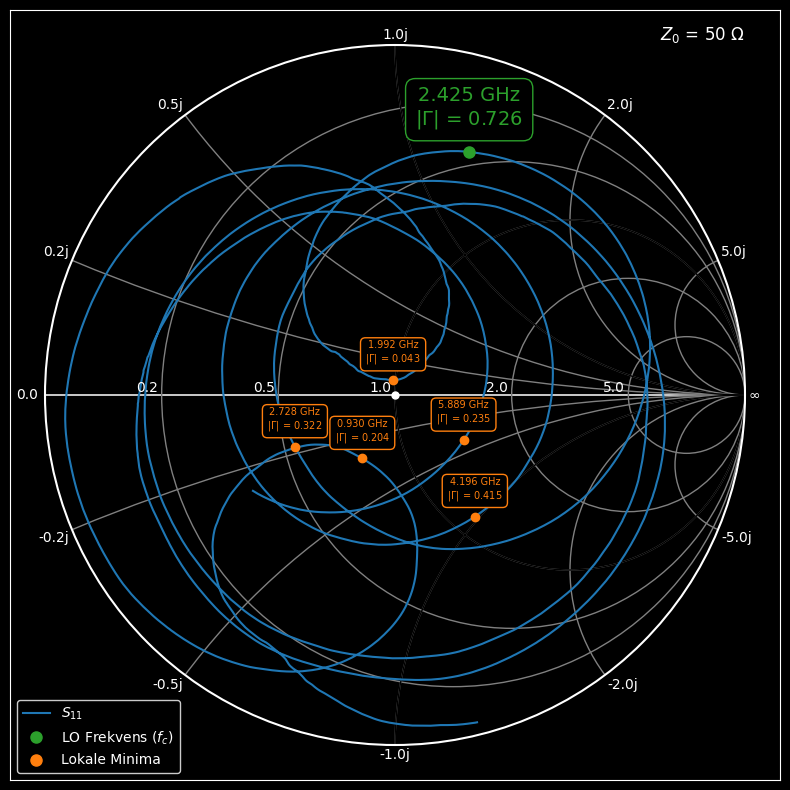

In [4]:
# ---- Smith Chart plot ----
plt.figure(figsize=(8, 8))

# Plot selve smith-chartet
antenne.plot_s_smith(m=0, color='tab:blue', lw=1.5, label=r"$S_{11}$",draw_labels=True)
fig_ax = plt.gca()

# Legg til ytterkant-sirkel
outer_circle = mpatches.Circle((0, 0), radius=1, transform=fig_ax.transData,
                               facecolor='none', edgecolor='white', linestyle='-', linewidth=1.5, zorder=5)
fig_ax.add_patch(outer_circle)
# Tilpass farger til mørk bakgrunn
fig_ax.spines['bottom'].set_color('white')
fig_ax.spines['top'].set_color('white')
fig_ax.spines['left'].set_color('white')
fig_ax.spines['right'].set_color('white')
fig_ax.tick_params(colors='white')
fig_ax.yaxis.label.set_color('white')
fig_ax.xaxis.label.set_color('white')
fig_ax.title.set_color('white')
fig_ax.tick_params(axis='x', colors='white') 
fig_ax.tick_params(axis='y', colors='white')

# Hent kompleks S11
s11_complex = antenne.s11.s.flatten()

# Marker LO frekvens
LO_s11_complex = s11_complex[freq_target_index]
gamma_mag = np.abs(LO_s11_complex)

plt.plot(np.real(LO_s11_complex), np.imag(LO_s11_complex), 'o', color='tab:green', markersize=8, label=r'LO Frekvens ($f_c$)')
plt.annotate(f"{LO_freq:.3f} GHz\n"+rf"|$\Gamma$| = {gamma_mag:.3f}", 
             xy=(np.real(LO_s11_complex), np.imag(LO_s11_complex)), 
             xytext=(0, 15), textcoords='offset points',
             color='tab:green', fontsize=14, va ='bottom', ha='center',
             bbox=dict(boxstyle="round,pad=0.5", edgecolor='tab:green', facecolor='black'))


# Marker lokale minima
for index, row in s11_minima.iterrows():
    idx = np.argmin(np.abs(freq - row['Frequency [GHz]']))
    z = s11_complex[idx]
    # annotate the best gamma value
    gamma_mag = np.abs(z)    
    plt.plot(np.real(z), np.imag(z), 'o', color='tab:orange', markersize=6)
    plt.annotate(f"{row['Frequency [GHz]']:.3f} GHz\n"+rf"|$\Gamma$| = {gamma_mag:.3f}", 
                 xy=(np.real(z), np.imag(z)), 
                 xytext=(0, 10), textcoords='offset points',
                 color='tab:orange', fontsize=7, va ='bottom', ha='center',
                 bbox=dict(boxstyle="round,pad=0.5", edgecolor='tab:orange', facecolor='black'))
    
plt.plot([], [], 'o', color='tab:orange', markersize=8, label="Lokale Minima")
plt.plot(0,0, 'o', color='white', markersize=5)

plt.annotate(r'$Z_0$ = 50 $\Omega$', xy=(1, 1), color='white', fontsize=12, ha='right', va='bottom')
# Grid og tittel
fig_ax.plot([-1, 1], [0, 0], color='white', linestyle='-', linewidth=1.2, zorder=0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend(loc='lower left', facecolor='black', edgecolor='white', labelcolor='white')
plt.tight_layout()
plt.savefig('Figurer/S11_Smith.pdf', bbox_inches='tight')
plt.show()